# 图像分类器

CIFAR10数据集，它包含十个类别:‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。CIFAR-10 中的图像尺寸为3*32*32，也就是RGB的3层颜色通道，每层通道内的尺寸为32*32。
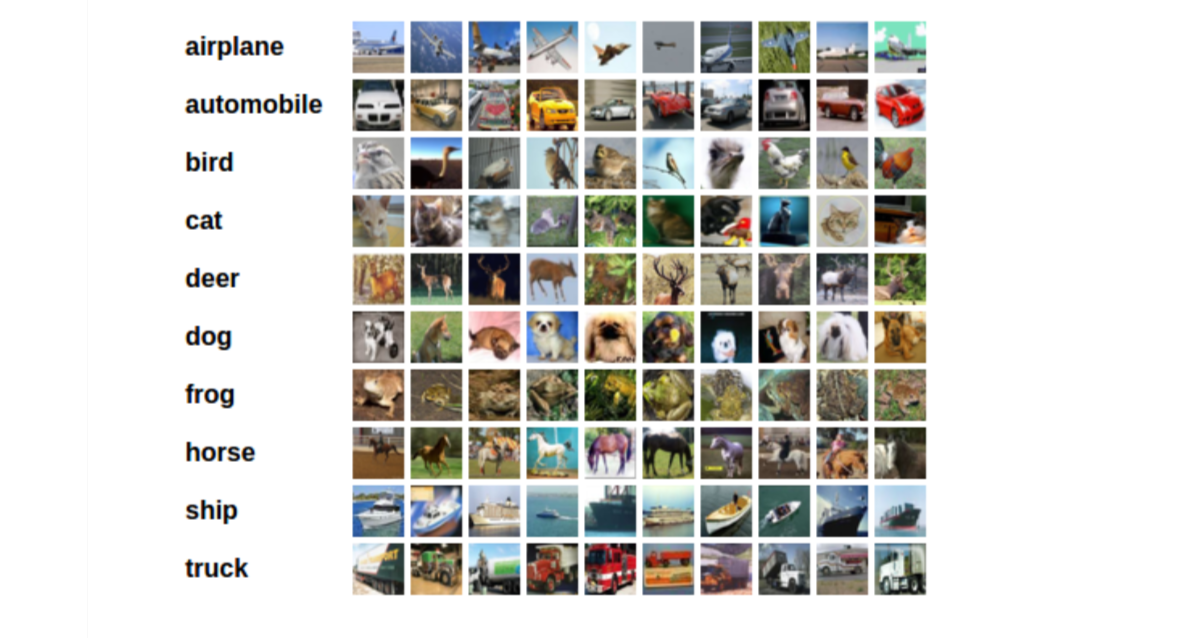

训练一个图像分类器 我们将按次序的做如下几步:
1. 使用torchvision加载并且归一化CIFAR10的训练和测试数据集
2. 定义一个卷积神经网络
3. 定义一个损失函数
4. 在训练样本数据上训练网络
5. 在测试样本数据上测试网络

## 1.加载数据集
- 数据集：Imagenet， CIFAR10，MNIST 等公共数据集的数据在 torchvision.datasets
- 数据加载和转换：加载图像数据、数据转换模块在 torch.utils.data.DataLoader
- 用外部库进行数据转换：如用图像处理库Pillow，OpenCV，将处理后的numpy array转成torch.Tensor即可

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# torchvision 数据集的输出是范围在[0,1]之间的 PILImage，我们将他们转换成归一化范围为[-1,1]之 间的张量 Tensors。
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #定义数据转换方法
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) #加载训练集，进行transform
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) #加载测试集，进行transform
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


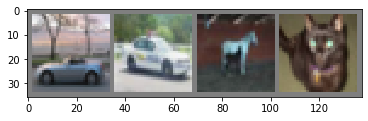

  car   car horse   cat


In [4]:
# 展示图片
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize，从[-1, 1]转换回[0,1]
    npimg = img.numpy() #从Tensor转换回numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #转换成3维后，展示
    plt.show()

dataiter = iter(trainloader) # get some random training images
images, labels = dataiter.next() # 0,1,2...,9
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join('%5s' % classes[labels[j]] for j in range(4))) # print labels

## 2. 定义神经网络

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input channel 3, output channel 6, kernel size (5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## 3. 定义优化器和损失函数

In [7]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 优化器
criterion = nn.CrossEntropyLoss() #损失准则

## 4. 训练网络

In [8]:
for epoch in range(2): # 训练的epochs次数
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #每个epoch内遍历所有的mini-batch
        inputs, labels = data # 训练数据
        optimizer.zero_grad() # 梯度置零
        outputs = net(inputs) # forward
        loss = criterion(outputs, labels) #loss
        loss.backward() # backward
        optimizer.step() # 更新梯度
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.286
[1,  4000] loss: 1.943
[1,  6000] loss: 1.726
[1,  8000] loss: 1.605
[1, 10000] loss: 1.535
[1, 12000] loss: 1.477
[2,  2000] loss: 1.426
[2,  4000] loss: 1.386
[2,  6000] loss: 1.368
[2,  8000] loss: 1.316
[2, 10000] loss: 1.302
[2, 12000] loss: 1.281
Finished Training


## 5. 用训练好的网络做预测

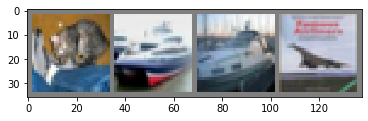

  cat  ship  ship plane


In [9]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
# 预测几张图片check性能
outputs = net(images)
y_pred, idx = torch.max(outputs, 1)
print(y, idx)
print('Predicted: ', ' '.join('%5s' % classes[idx[j]] for j in range(4)))

tensor([2.5874, 6.0175, 2.1945, 4.2899], grad_fn=<MaxBackward0>) tensor([3, 8, 0, 0])
Predicted:    cat  ship plane plane


In [14]:
# 评估在整个测试集上的表现：这看起来比随机预测要好，随机预测的准确率为10%(随机预测出为10类中的哪一类)，看来网络学到了东西。
correct = 0
total = 0
with torch.no_grad(): #预测时要关掉反向传播
    for data in testloader:
        images, labels = data
        outputs = net(images)
        y_pred, idx = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (idx == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [15]:
# 分别查看10类各自的准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad(): #预测时要关掉反向传播
    for data in testloader:
        images, labels = data
        outputs = net(images)
        y_pred, idx = torch.max(outputs, 1)
        c = (idx == labels).squeeze()
        for i in range(4): #因为batch_size = 4
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 71 %
Accuracy of  bird : 38 %
Accuracy of   cat : 59 %
Accuracy of  deer : 46 %
Accuracy of   dog : 27 %
Accuracy of  frog : 67 %
Accuracy of horse : 63 %
Accuracy of  ship : 52 %
Accuracy of truck : 61 %
